In [1]:
import importlib, os, gc, sys
import SXBQ as sx
import WMT_functions as wmt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

import matplotlib.colors as cl
from gsw import z_from_p, p_from_z, distance, SA_from_SP, CT_from_t, rho, distance, cp_t_exact


from scipy.signal import find_peaks
from scipy.stats import linregress


from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1.6)

import warnings
warnings.filterwarnings('ignore')

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

# Load data

In [4]:
ds_79=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_pp_pressure.nc')


group_trans=ds_79.groupby_bins('transect_num', bins=np.arange(0,ds_79.transect_num.max(),1))

# for i in tqdm(range(len(list(group_trans.groups.keys())))):
#     ds_=group_trans[list(group_trans.groups.keys())[i]]#.unstack('stacked_pressure')
#     ds_['transect_number']=i+1
#     ds_=ds_.expand_dims('transect_number')
#     if i==1:
#         ds2_=ds_.copy()
#     if i>1:
#         ds2_=xr.concat([ds2_, ds_], 'transect_number')
        
        
def data_grid_roll(DS, climat_or_transect, month, var): # month, cons_temp, abs_salinity ,  potential_density , spice
    if climat_or_transect=='month':
        get_section1=DS.groupby('t.month')[month]
        def roll(ds):
            ds = pd.DataFrame(ds).interpolate(limit=5,axis=0).interpolate(limit=2,axis=1).rolling(5,axis=0, center=True).mean().rolling(10,axis=1, center=True).mean()
            return ds.to_numpy()
        dx, dy=1, 1
        xaxis=np.arange(0,80+dx,dx)
        yaxis=np.arange(0,500+dy,dy)

    elif climat_or_transect=='transect':
        get_section1=ds2_.sel(transect_number=month).where(ds2_.sel(transect_number=month).cons_temp.count('pressure')!=0, drop=True)
        def roll(ds):
            # ds = pd.DataFrame(ds).interpolate(limit=5,axis=0).interpolate(limit=2,axis=1).rolling(5,axis=0, center=True).mean().rolling(5,axis=1, center=True).mean()
            ds = pd.DataFrame(ds).interpolate(limit=2,axis=1).rolling(3,axis=1, center=True).mean()
            
            return ds.to_numpy()
        dx, dy=2, 0.5
        xaxis=np.arange(0,80+dx,dx)
        yaxis=np.arange(0,500+dy,dy)

    XX1, YY1=np.meshgrid(get_section1.distance_bin_on_transect,  get_section1.pressure)
    ct1, _ ,_=sx.grid2d(XX1.flatten(), YY1.flatten(), get_section1[var].values.flatten(), xi=xaxis, yi=yaxis, fn='mean')
    
    return roll(ct1)[:, int(10/dx):int(-7/dx)]


ds2_=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/3_MW_budget_data/data/sea079_by_transect.nc')



# dataset='climat'
dataset='glider'

if dataset=='glider':
    dx, dy=2, 0.5
climat_or_transect='transect'

S_var='spice'  
T_var='potential_density'   

## CHANGE RANGES AND dS dT if change to Sal Temp!!
dS = 0.1   #0.2
dT = 0.05  #0.03    # 0.1 
S_range = (1, 9)  
T_range =  (22, 28)

## WMT sigma-spice PER TRANSECT

In [5]:
import importlib
importlib.reload(wmt)

DS=ds_79.copy()

open_or_close='open'
# dx, dy=2, 2
def get_mean_time_transect(month_i):
    tid_=pd.to_datetime(ds2_.sel(transect_number=month_i).where(ds2_.sel(transect_number=month_i).cons_temp.count('pressure')!=0, drop=True).time.mean('pressure').mean().item())
    return tid_

deltatimesss_=[]
for ii in tqdm(range(5,24)):  ##          24         month_i is transect number actually...
# for month_i in tqdm(range(19,26)):  ##month_i is transect number actually...
# for month_i in tqdm(range(38,42)):  ##month_i is transect number actually...
    month_i=ii
    month_f=ii+1
    # dt=(month_f-month_i)*30*24*60*60
    print(get_mean_time_transect(month_i))
    ti1, ti2=get_mean_time_transect(month_i), get_mean_time_transect(month_f)
    # days_range=(ti2-ti1).values.astype('timedelta64[D]').astype(int)
    days_range=((ti2-ti1).round('D')/ np.timedelta64(1, 'D'))# (ti2-ti1).astype('timedelta64[D]').astype(int)
    
    dt=int((days_range)*24*60*60)
    deltatimesss_.append(dt)
    t_arr=np.array([get_mean_time_transect(month_i),
                    get_mean_time_transect(month_i)+(get_mean_time_transect(month_f)-get_mean_time_transect(month_i))/2,
                    get_mean_time_transect(month_f)])

    salinity_noflat=[data_grid_roll(DS, climat_or_transect, month_i, S_var), 
                     data_grid_roll(DS,climat_or_transect, month_i, S_var), 
                     data_grid_roll(DS,climat_or_transect, month_f, S_var)]
    temperature_noflat=[data_grid_roll(DS,climat_or_transect, month_i, T_var), 
                        data_grid_roll(DS,climat_or_transect, month_i, T_var), 
                        data_grid_roll(DS,climat_or_transect, month_f, T_var)]

    salinity=[data_grid_roll(DS,climat_or_transect, month_i, S_var).flatten(), data_grid_roll(DS,climat_or_transect,month_i, S_var).flatten(), data_grid_roll(DS,climat_or_transect, month_f, S_var).flatten()]
    temperature=[data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten(), data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten(), data_grid_roll(DS,climat_or_transect, month_f, T_var).flatten()]
    salinity_surf=[np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, S_var)[:3, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, S_var)[:3, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_f, S_var)[:3, :] , axis=0)]
    temperature_surf=[np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, T_var)[:3, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, T_var)[:3, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_f, T_var)[:3, :] , axis=0)]

   

    ## compute transformation      
    ts_trans = wmt.mk_ts_trans_ds(dS, dT, S_range, T_range, t_arr)
    #cal area
    ts_trans = wmt.calc_ts_area(salinity, temperature,salinity_noflat,temperature_noflat,   ts_trans, dx, dy,open_or_close).fillna(0)
    # calc transformation
    ts_trans = wmt.ts_trans_cdiff(ts_trans,  dt)

    # print('done')

    ts_trans['dvol_G']=ts_trans.dvol_G.where(ts_trans.dvol_G!=0)
    ts_trans['G_s']=ts_trans.G_s.where(ts_trans.G_s!=0)
    ts_trans['G_t']=ts_trans.G_t.where(ts_trans.G_t!=0)

    ts_trans['epsilon']=ts_trans.epsilon.where(ts_trans.epsilon!=0)
    

  0%|          | 0/19 [00:00<?, ?it/s]

2015-03-26 16:03:00.036720384
2015-03-29 14:12:08.244002560
2015-04-02 01:40:09.774830848
2015-04-04 18:56:47.167101184
2015-04-08 11:07:51.542471680
2015-04-11 07:33:14.447755520
2015-04-15 10:13:15.925331712
2015-04-18 05:22:01.517041664
2015-04-22 12:14:45.946967040
2015-04-25 14:29:29.369618944
2015-04-29 15:08:27.809085696
2015-05-02 05:41:32.321417984
2015-05-05 22:27:36.061637632
2015-05-08 15:05:56.332782848
2015-05-12 12:11:03.112801792
2015-05-15 09:50:22.730059008
2015-05-18 15:41:14.567891712
2015-05-21 10:42:24.447760128
2015-05-24 20:47:56.648388864


## other variables

In [35]:
for ind_, ii in tqdm(enumerate(range(5,24))):  ##          24         month_i is transect number actually...    
    bin2_3D=data_grid_roll(DS,climat_or_transect, month_i, S_var).flatten()
    bin1_3D=data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten()
    bin_edge1 = ts_trans.T_bin
    bin_edge2 = ts_trans.S_bin
    month_i=ii
    var_3D = data_grid_roll(DS,climat_or_transect, month_i, 'aou').flatten()
        
    out = sx.grid2d(bin1_3D, bin2_3D, var_3D, 
                        xi=bin_edge1[:-1], yi=bin_edge2[:-1],
                        fn='mean')
    ts_trans_all['ts_aou'][:, :, 2*ind_] = out[0].T

ts_trans_all['ts_aou']=ts_trans_all['ts_aou'].where(ts_trans_all['ts_aou']!=0, np.nan)

0it [00:00, ?it/s]

In [36]:
for ind_, ii in tqdm(enumerate(range(5,24))):  ##          24         month_i is transect number actually...    
    bin2_3D=data_grid_roll(DS,climat_or_transect, month_i, S_var).flatten()
    bin1_3D=data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten()
    bin_edge1 = ts_trans.T_bin
    bin_edge2 = ts_trans.S_bin
    month_i=ii
    var_3D = data_grid_roll(DS,climat_or_transect, month_i, 'oxygen_concentration').flatten()
        
    out = sx.grid2d(bin1_3D, bin2_3D, var_3D, 
                        xi=bin_edge1[:-1], yi=bin_edge2[:-1],
                        fn='mean')
    ts_trans_all['ts_oxygen_concentration'][:, :, 2*ind_] = out[0].T

ts_trans_all['ts_oxygen_concentration']=ts_trans_all['ts_oxygen_concentration'].where(ts_trans_all['ts_oxygen_concentration']!=0, np.nan)

0it [00:00, ?it/s]

In [37]:
for ind_, ii in tqdm(enumerate(range(5,24))):  ##          24         month_i is transect number actually...    
    bin2_3D=data_grid_roll(DS,climat_or_transect, month_i, S_var).flatten()
    bin1_3D=data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten()
    bin_edge1 = ts_trans.T_bin
    bin_edge2 = ts_trans.S_bin
    month_i=ii
    var_3D = data_grid_roll(DS,climat_or_transect, month_i, 'potential_density').flatten()
        
    out = sx.grid2d(bin1_3D, bin2_3D, var_3D, 
                        xi=bin_edge1[:-1], yi=bin_edge2[:-1],
                        fn='mean')
    ts_trans_all['ts_T'][:, :, 2*ind_] = out[0].T

ts_trans_all['ts_T']=ts_trans_all['ts_T'].where(ts_trans_all['ts_T']!=0, np.nan)


0it [00:00, ?it/s]

In [38]:
for ind_, ii in tqdm(enumerate(range(5,24))):  ##          24         month_i is transect number actually...    
    bin2_3D=data_grid_roll(DS,climat_or_transect, month_i, S_var).flatten()
    bin1_3D=data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten()
    bin_edge1 = ts_trans.T_bin
    bin_edge2 = ts_trans.S_bin
    month_i=ii
    var_3D = data_grid_roll(DS,climat_or_transect, month_i, 'spice').flatten()
        
    out = sx.grid2d(bin1_3D, bin2_3D, var_3D, 
                        xi=bin_edge1[:-1], yi=bin_edge2[:-1],
                        fn='mean')
    ts_trans_all['ts_S'][:, :, 2*ind_] = out[0].T

ts_trans_all['ts_S']=ts_trans_all['ts_S'].where(ts_trans_all['ts_T']!=0, np.nan)


0it [00:00, ?it/s]

## save

In [107]:
ts_trans_all_glider_79=ts_trans_all.copy()
deltatimesss_79=deltatimesss_
ts_trans_all_glider_79['delta_time']=(ts_trans_all_glider_79.time_mid.copy().astype(float)*np.nan)
ts_trans_all_glider_79['delta_time']=('time_mid', deltatimesss_)

ts_trans_all_glider_79.to_netcdf('sensitivity_tests/WMT_sg079_0.1_0.05.nc')

# WMT in TS space

In [ ]:
# dataset='climat'
dataset='glider'

if dataset=='glider':
    dx, dy=2, 0.5
climat_or_transect='transect'
## ON WHAT VARIABLE:

S_var='abs_salinity'  # or 'spice'
T_var='cons_temp'   # or 'potential_density'
dS = 0.03   #0.2
dT = 0.3    # 0.1 
S_range = (35, 38)  # (1, 9)
T_range = (10, 32)  # (22, 28)


In [6]:
DS=ds_79.copy()

open_or_close='open'
# dx, dy=2, 2
def get_mean_time_transect(month_i):
    tid_=pd.to_datetime(ds2_.sel(transect_number=month_i).where(ds2_.sel(transect_number=month_i).cons_temp.count('pressure')!=0, drop=True).time.mean('pressure').mean().item())
    return tid_
# ti1, ti2=get_mean_time_transect(month_i), get_mean_time_transect(month_f)
# days_range=((ti2-ti1).round('D')/ np.timedelta64(1, 'D'))# (ti2-ti1).astype('timedelta64[D]').astype(int)
# dt=(days_range)*24*60*60

# month_i,month_f=3,5
# xaxis=np.arange(0,80+dx,dx)[int(20/dx):int(-10/dx)]
# yaxis=np.arange(0,500+dy,dy)
deltatimesss_=[]
for ii in tqdm(range(5,24)):  ##          24         month_i is transect number actually...
# for month_i in tqdm(range(19,26)):  ##month_i is transect number actually...
# for month_i in tqdm(range(38,42)):  ##month_i is transect number actually...
    month_i=ii
    month_f=ii+1
    # dt=(month_f-month_i)*30*24*60*60

    ti1, ti2=get_mean_time_transect(month_i), get_mean_time_transect(month_f)
    # days_range=(ti2-ti1).values.astype('timedelta64[D]').astype(int)
    days_range=((ti2-ti1).round('D')/ np.timedelta64(1, 'D'))# (ti2-ti1).astype('timedelta64[D]').astype(int)
    
    dt=(days_range)*24*60*60
    deltatimesss_.append(dt)
    t_arr=np.array([get_mean_time_transect(month_i),
                    get_mean_time_transect(month_i)+(get_mean_time_transect(month_f)-get_mean_time_transect(month_i))/2,
                    get_mean_time_transect(month_f)])

    salinity_noflat=[data_grid_roll(DS, climat_or_transect, month_i, S_var), 
                     data_grid_roll(DS,climat_or_transect, month_i, S_var), 
                     data_grid_roll(DS,climat_or_transect, month_f, S_var)]
    temperature_noflat=[data_grid_roll(DS,climat_or_transect, month_i, T_var), 
                        data_grid_roll(DS,climat_or_transect, month_i, T_var), 
                        data_grid_roll(DS,climat_or_transect, month_f, T_var)]

    salinity=[data_grid_roll(DS,climat_or_transect, month_i, S_var).flatten(), data_grid_roll(DS,climat_or_transect,month_i, S_var).flatten(), data_grid_roll(DS,climat_or_transect, month_f, S_var).flatten()]
    temperature=[data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten(), data_grid_roll(DS,climat_or_transect, month_i, T_var).flatten(), data_grid_roll(DS,climat_or_transect, month_f, T_var).flatten()]
    salinity_surf=[np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, S_var)[:10, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, S_var)[:10, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_f, S_var)[:10, :] , axis=0)]
    temperature_surf=[np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, T_var)[:10, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_i, T_var)[:10, :] , axis=0), np.nanmean(data_grid_roll(DS,climat_or_transect, month_f, T_var)[:10, :] , axis=0)]

   

    ## compute transformation      
    ts_trans = wmt.mk_ts_trans_ds(dS, dT, S_range, T_range, t_arr)
    #cal area
    ts_trans = wmt.calc_ts_area(salinity, temperature,salinity_noflat,temperature_noflat,   ts_trans, dx, dy,open_or_close).fillna(0)
    # calc transformation
    ts_trans = wmt.ts_trans_cdiff(ts_trans,  dt)

    # print('done')

    if S_var=='abs_salinity':

        ## for diahaline thermal fluxes::
        ## calc surface fluxes transf

        path='/home/jupyter-estelfont/scratch/estel/datasets/ERA5/L0/climatology/'
        files= [f for f in os.listdir(path) if f.endswith('.nc')]
        files=['/home/jupyter-estelfont/scratch/estel/datasets/ERA5/L0/climatology/'+files[i] for i in range(8)]
        df_era= xr.open_mfdataset(files)
        # ERA5=era_to_PWP(df_era

        era5_dset=df_era.sel(time=slice('2015', '2015'), latitude=24, longitude=59)

        era5_dset=era5_dset.resample(time='15d').mean()
        era5_dset = era5_dset.interp(time=ts_trans.time_mid)
        qnet = (era5_dset.msshf + era5_dset.mslhf + era5_dset.msnlwrf + era5_dset.msnswrf)
        fw = (era5_dset.mer/1000 + era5_dset.mtpr/1000)

        # Calculate the air-sea flux transformation
        ts_trans = wmt.calc_surf_trans(
            ts_trans, qnet, fw, temperature_surf, salinity_surf, 
            era5_dset.longitude, 
            era5_dset.latitude,
            )

        ## calc residual (total - ariseafluxes)

        ts_trans['dvol_F'] = ts_trans.dvol_G.fillna(0) - ts_trans.dvol_E.fillna(0)
        ts_trans['dvol_F'] = ts_trans.dvol_F.where(~np.isnan(ts_trans['dvol_F']), 0)

        ts_trans = wmt.calc_osanp_F(ts_trans, dt)

        ts_trans['dvol_E']=ts_trans.dvol_E.where(ts_trans.dvol_E!=0)
        ts_trans['E_s']=ts_trans.E_s.where(ts_trans.E_s!=0)
        ts_trans['E_t']=ts_trans.E_t.where(ts_trans.E_t!=0)


        ts_trans['dvol_F']=ts_trans.dvol_F.where(ts_trans.dvol_F!=0)
        ts_trans['F_s']=ts_trans.F_s.where(ts_trans.F_s!=0)
        ts_trans['F_t']=ts_trans.F_t.where(ts_trans.F_t!=0)


    ts_trans['dvol_G']=ts_trans.dvol_G.where(ts_trans.dvol_G!=0)
    ts_trans['G_s']=ts_trans.G_s.where(ts_trans.G_s!=0)
    ts_trans['G_t']=ts_trans.G_t.where(ts_trans.G_t!=0)

    ts_trans['epsilon']=ts_trans.epsilon.where(ts_trans.epsilon!=0)
    
    # if month_i==38:
    if month_i==5:
    # if month_i==19:
        ts_trans_all=ts_trans.copy()
    elif month_i>5:
        ts_trans_all=xr.merge([ts_trans_all, ts_trans])

  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
# ts_trans_all.to_netcdf('/home/jupyter-estelfont/scratch/estel/datasets/3_MW_budget_data/data/out_WMT/WMT_sg079_step_1transect_TS.nc')

### Figure S2

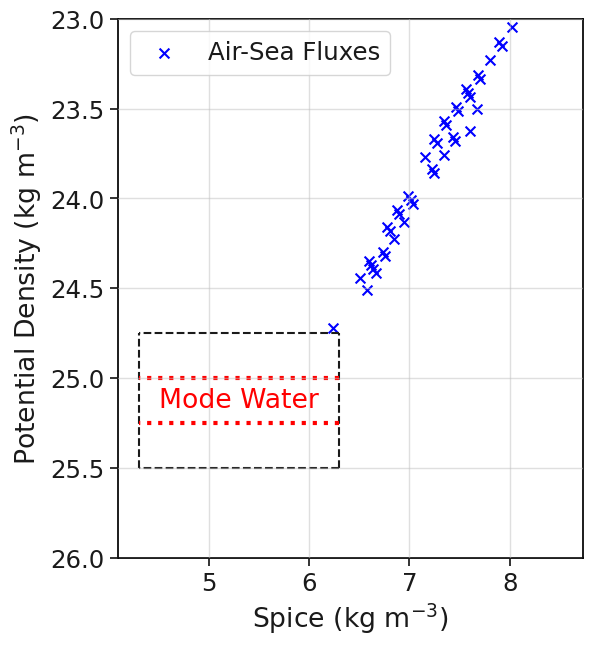

In [9]:
glider_TS=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/3_MW_budget_data/data/out_WMT/WMT_sg079_step_1transect_TS.nc')
flagged_TS_buoyancyflux = glider_TS.dvol_E.where( glider_TS.dvol_E!=0, np.nan).sum('time_mid').where(glider_TS.dvol_E.where( glider_TS.dvol_E!=0, np.nan).sum('time_mid')!=0, np.nan)

mask = ~np.isnan(flagged_TS_buoyancyflux)

T, S = xr.broadcast(flagged_TS_buoyancyflux['T_bini'], flagged_TS_buoyancyflux['S_bini'])
Tbini_notnan = T.where(mask, drop=True).values.flatten()
Sbini_notnan = S.where(mask, drop=True).values.flatten()

sigmas_=gsw.sigma0(Sbini_notnan, Tbini_notnan)
spices_=gsw.spiciness0(Sbini_notnan, Tbini_notnan)


plt.figure(figsize=(6,7))
plt.scatter(spices_, sigmas_, marker='x', c='blue', s=50, label='Air-Sea Fluxes')
plt.ylim(26, 23)
plt.legend()
plt.plot([4.3,4.3], [25.5,24.75], c='k', ls='--')
plt.plot([6.3,6.3], [25.5,24.75], c='k', ls='--')
plt.plot([6.3,4.3], [25.5,25.5], c='k', ls='--')
plt.plot([6.3,4.3], [24.75,24.75], c='k', ls='--')

plt.plot([6.3,4.3], [25,25], c='red', ls=':', lw=3)
plt.plot([6.3,4.3], [25.25,25.25], c='red', ls=':', lw=3)
plt.text(4.5, 25.125, 'Mode Water', va='center', c='red')

plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Spice (kg m$^{-3}$)')

plt.grid( c='silver', alpha=.5)